In [1]:
import math
import mldatasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
from alibi.explainers import AnchorTabular
from alibi.explainers import CEM
from alibi.explainers import CounterFactualProto
import shap
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [2]:
print(tf.__version__)

2.2.0


In [3]:
tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly()) 

Eager execution enabled:  False


In [4]:
recidivism_df = mldatasets.load("recidivism-risk", prepare=True)

https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv downloaded to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter7/data/cox-violent-parsed_filt.csv
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter7/data folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/_packt_git/Interpretable-Machine-Learning-with-Python/Chapter7/data/cox-violent-parsed_filt.csv


In [5]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14788 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    14788 non-null  int8 
 1   juv_fel_count          14788 non-null  int8 
 2   juv_misd_count         14788 non-null  int8 
 3   juv_other_count        14788 non-null  int64
 4   priors_count           14788 non-null  int8 
 5   is_recid               14788 non-null  int8 
 6   sex_Female             14788 non-null  uint8
 7   sex_Male               14788 non-null  uint8
 8   race_African-American  14788 non-null  uint8
 9   race_Asian             14788 non-null  uint8
 10  race_Caucasian         14788 non-null  uint8
 11  race_Hispanic          14788 non-null  uint8
 12  race_Native American   14788 non-null  uint8
 13  race_Other             14788 non-null  uint8
 14  c_charge_degree_(F1)   14788 non-null  uint8
 15  c_charge_degree_(F2)   14788 non-nul

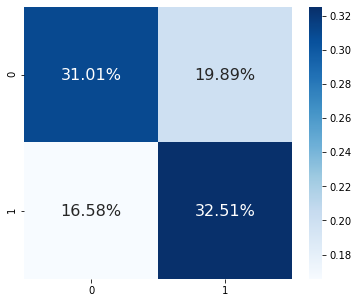

In [6]:
cf_matrix = metrics.confusion_matrix(recidivism_df.is_recid,\
                                     recidivism_df.compas_score)
plt.figure(figsize=(6, 5))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16})

In [7]:
recidivism_c_df = recidivism_df[recidivism_df['race_Caucasian'] == 1]
recidivism_aa_df = recidivism_df[recidivism_df['race_African-American'] == 1]

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


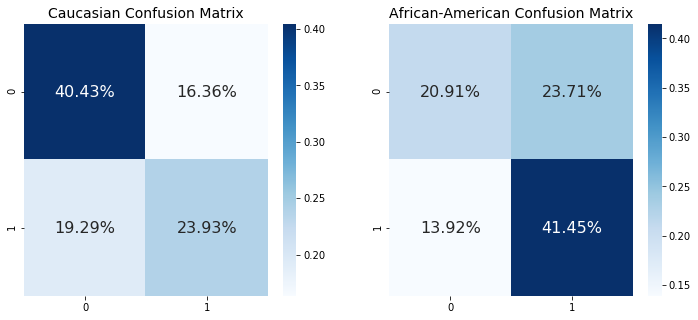

In [8]:
cf_c_matrix = metrics.confusion_matrix(recidivism_c_df.is_recid,\
                                     recidivism_c_df.compas_score)
cf_aa_matrix = metrics.confusion_matrix(recidivism_aa_df.is_recid,\
                                     recidivism_aa_df.compas_score)
fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.heatmap(cf_c_matrix/np.sum(cf_c_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
ax[0].set_title('Caucasian Confusion Matrix', fontsize=14)
sns.heatmap(cf_aa_matrix/np.sum(cf_aa_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
ax[1].set_title('African-American Confusion Matrix', fontsize=14)
fig.show()

In [9]:
tn, fp, fn, tp = cf_aa_matrix.ravel()
fpr_aa = fp/(fp+tn)
tn, fp, fn, tp = cf_c_matrix.ravel()
fpr_c = fp/(fp+tn)
print("African-American FPR:\t%.1f%%" % (fpr_aa*100))
print("Caucasian FPR:\t\t%.1f%%" % (fpr_c*100))
print("AA-FPR/C-FPR:\t\t%.2f x" % (fpr_aa/fpr_c))

African-American FPR:	53.1%
Caucasian FPR:		28.8%
AA-FPR/C-FPR:		1.84 x


In [10]:
rand = 9
np.random.seed(rand)
tf.random.set_seed(rand)

y = recidivism_df['compas_score']
X = recidivism_df.drop(['compas_score', 'is_recid'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

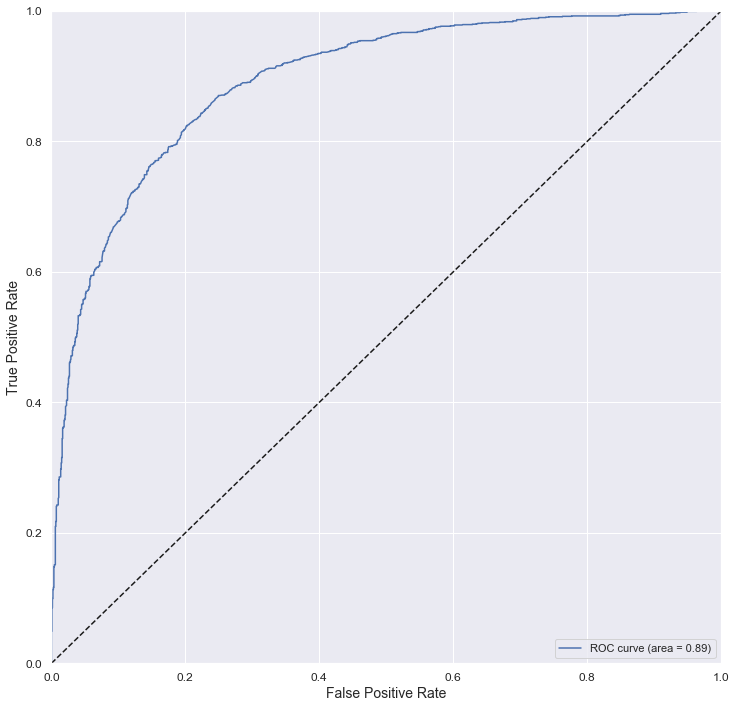

Accuracy_train:  0.8790		Accuracy_test:   0.8087
Precision_test:  0.8277		Recall_test:     0.8110
ROC-AUC_test:    0.8927		F1_test:         0.8193		MCC_test: 0.6162


In [11]:
sns.set()
cb_mdl = CatBoostClassifier(iterations=500, learning_rate=0.5, depth=8)
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)
y_train_cb_pred, y_test_cb_prob, y_test_cb_pred =\
        mldatasets.evaluate_class_mdl(fitted_cb_mdl, X_train,\
                                      X_test, y_train, y_test)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


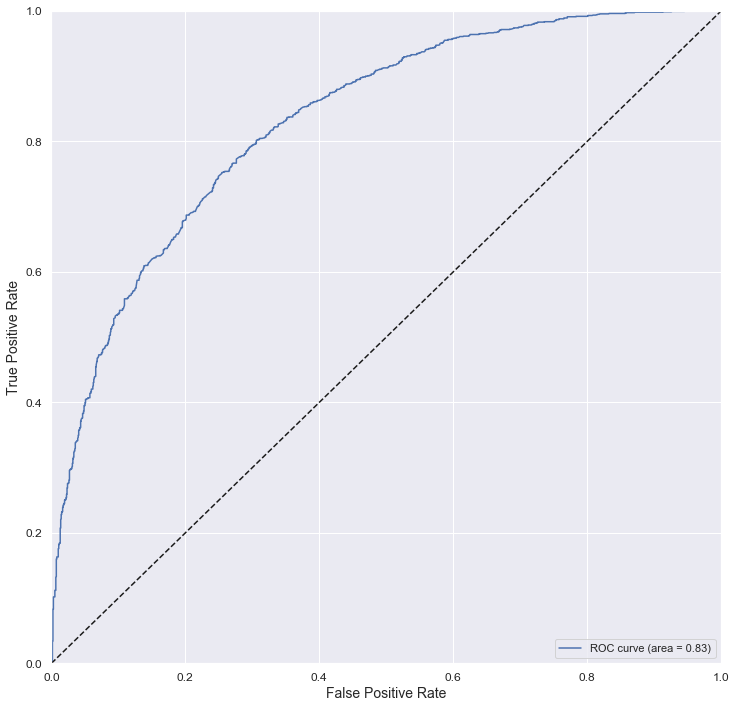

Accuracy_train:  0.7527		Accuracy_test:   0.7471
Precision_test:  0.7653		Recall_test:     0.7604
ROC-AUC_test:    0.8320		F1_test:         0.7628		MCC_test: 0.4920


In [12]:
fitted_nn_mdl = keras.Sequential([
    tf.keras.Input(shape=[len(X_train.keys())]),
    layers.Dense(7, activation='relu'),
    layers.Dense(1, activation='sigmoid')
  ])
fitted_nn_mdl.compile(loss='mean_squared_error', optimizer='adam')
nn_history = fitted_nn_mdl.fit(X_train.values, y_train.values, epochs=12,\
                               batch_size=32, validation_split=0.2, verbose=0)
y_train_nn_pred, y_test_nn_prob, y_test_nn_pred =\
        mldatasets.evaluate_class_mdl(fitted_nn_mdl, X_train,\
                                      X_test, y_train, y_test)

In [13]:
idx1 = 5231
idx2 = 2726
idx3 = 10127
eval_idxs = X_test.index.isin([idx1, idx2, idx3])
X_test_evals = X_test[eval_idxs]
eval_compare_df = pd.concat([\
            pd.DataFrame({'y':y_test[eval_idxs]},\
                         index=[idx3, idx2, idx1]),\
            pd.DataFrame({'y_pred':y_test_cb_pred[eval_idxs]},\
                         index=[idx3, idx2, idx1]),\
            X_test_evals], axis=1).transpose()
eval_compare_df

,10127,2726,5231
y,0,0,1
y_pred,0,0,1
age,24,23,23
juv_fel_count,0,0,0
juv_misd_count,0,0,0
juv_other_count,0,0,0
priors_count,2,2,2
sex_Female,0,0,0
sex_Male,1,1,1
race_African-American,0,0,1


In [14]:
class_names = ['Low Risk', 'Medium/High Risk']

In [15]:
X_test_eval = np.expand_dims(X_test.values[X_test.\
                                           index.get_loc(idx1)], axis=0)
print(X_test_eval)

[[23  0  0  0  2  0  1  1  0  0  0  0  0  0  0  0  1  0  0  0  0]]


In [16]:
cat_vars_ohe = {5: 2, 7: 6, 13: 8}
print(ohe_to_ord(X_test_eval, cat_vars_ohe)[0])

[[23  0  0  0  2  1  0  3]]


In [17]:
category_map = {
    5: ['Female', 'Male'],
    6: ['African-American', 'Asian', 'Caucasian',\
        'Hispanic', 'Native American', 'Other'],
    7: ['Felony 1st Degree', 'Felony 2nd Degree',\
        'Felony 3rd Degree', 'Felony 7th Degree',\
        'Misdemeanor 1st Degree', 'Misdemeanor 2nd Degree',\
        'Misdemeanor 3rd Degree', 'Other Charge Degree']
}
feature_names = ['age', 'juv_fel_count', 'juv_misd_count',\
                 'juv_other_count', 'priors_count', 
                 'sex', 'race', 'c_charge_degree']

In [18]:
category_map_ohe = {5: ['Not Female', 'Female'], 6: ['Not Male', 'Male'],\
        7:['Not African American', 'African American'],\
        8:['Not Asian', 'Asian'], 9:['Not Caucasian', 'Caucasian'],\
        10:['Not Hispanic', 'Hispanic'],\
        11:['Not Native American', 'Native American'],\
        12:['Not Other Race', 'Other Race'],\
        13:['Not Felony 1st Level', 'Felony 1st Level'],\
        14:['Not Felony 2nd Level', 'Felony 2nd Level'],\
        15:['Not Felony 3rd Level', 'Felony 3rd Level'],\
        16:['Not Felony 7th Level', 'Felony 7th Level'],\
        17:['Not Misdemeanor 1st Deg', 'Misdemeanor 1st Deg'],\
        18:['Not Misdemeanor 2nd Deg', 'Misdemeanor 2nd Deg'],\
        19:['Not Misdemeanor 3rd Deg', 'Misdemeanor 3rd Deg'],\
        20:['Not Other Charge Degree', 'Other Charge Degree']}

In [19]:
predict_cb_fn = lambda x: fitted_cb_mdl.predict_proba(x)
anchor_cb_explainer = AnchorTabular(predict_cb_fn, X_train.columns,\
                                    categorical_names=category_map_ohe)
anchor_cb_explainer.fit(X_train.values)

AnchorTabular(meta={
    'name': 'AnchorTabular',
    'type': ['blackbox'],
    'explanations': ['local'],
    'params': {'seed': None, 'disc_perc': (25, 50, 75)}
})

In [20]:
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[idx1].values)[0]])

Prediction: Medium/High Risk


In [21]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx1].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: age <= 25.00 AND
	priors_count > 0.00
Precision: 0.866
Coverage: 0.290


In [22]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx1].values, threshold=0.9,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American AND
	c_charge_degree_(M1) = Not Misdemeanor 1st Deg AND
	sex_Female = Not Female
Precision: 0.903
Coverage: 0.290


In [23]:
predict_nn_fn = lambda x: np.concatenate((1 - fitted_nn_mdl.predict(x),\
                                          fitted_nn_mdl.predict(x)), axis=1)
anchor_nn_explainer = AnchorTabular(predict_nn_fn, X_train.columns,\
                                    categorical_names=category_map_ohe)
anchor_nn_explainer.fit(X_train.values)

AnchorTabular(meta={
    'name': 'AnchorTabular',
    'type': ['blackbox'],
    'explanations': ['local'],
    'params': {'seed': None, 'disc_perc': (25, 50, 75)}
})

In [24]:
anchor_nn_explanation =\
    anchor_nn_explainer.explain(X_test.loc[idx3].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_nn_explanation.anchor)))
print('Precision: %.3f' % anchor_nn_explanation.precision)
print('Coverage: %.3f' % anchor_nn_explanation.coverage)

Anchor: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	c_charge_degree_(F3) = Not Felony 3rd Level
Precision: 0.910
Coverage: 0.578


In [25]:
anchor_nn_explanation =\
    anchor_nn_explainer.explain(X_test.loc[idx2].values, threshold=0.85,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_nn_explanation.anchor)))
print('Precision: %.3f' % anchor_nn_explanation.precision)
print('Coverage: %.3f' % anchor_nn_explanation.coverage)

Anchor: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	race_Caucasian = Not Caucasian
Precision: 0.872
Coverage: 0.578


In [26]:
feature_range = (X_train.values.min(axis=0).reshape(1,21).astype(np.float32),\
                 X_train.values.max(axis=0).reshape(1,21).astype(np.float32))
print(feature_range)

(array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[96., 20., 13., 11., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32))


In [27]:
cf_nn_explainer = CounterFactualProto(predict_nn_fn,
                                    X_test_eval.shape,
                                    max_iterations=100,
                                    feature_range=feature_range, 
                                    beta=.1, theta=5,
                                    use_kdtree=True
                                )
cf_nn_explainer.fit(X_test.values, d_type='abdm-mvdm')

CounterFactualProto(meta={
    'name': 'CounterFactualProto',
    'type': ['blackbox', 'tensorflow', 'keras'],
    'explanations': ['local'],
    'params': {
        'kappa': 0.0,
        'beta': 0.1,
        'feature_range': (
            array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32),
            array([[96., 20., 13., 11., 38.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)
        ),
        'gamma': 0.0,
        'theta': 5,
        'cat_vars': None,
        'ohe': False,
        'use_kdtree': True,
        'learning_rate_init': 0.01,
        'max_iterations': 100,
        'c_init': 10.0,
        'c_steps': 10,
        'eps': (0.001, 0.001),
        'clip': (-1000.0, 1000.0),
        'update_num_grad': 1,
        'write_dir': None,
        'shape': (1, 21),
        'is_model': False,
        'is_model_keras': False,
        'is_ae': Fa

In [28]:
cf_nn_explanation = cf_nn_explainer.explain(X_test_eval)
mldatasets.describe_cf_instance(X_test_eval, cf_nn_explanation, class_names,\
                  cat_vars_ohe, category_map, feature_names)

Instance Outcomes and Probabilities
------------------------------------------------
       original:  Medium/High Risk
                  [0.46732193 0.53267807]
 counterfactual:  Low Risk
                  [0.50025815 0.49974185]

Categorical Feature Counterfactual Perturbations
------------------------------------------------
	            sex:  Male  -->  Female
	           race:  African-American  -->  Asian
	c_charge_degree:  Felony 7th Degree  -->  Felony 1st Degree

Numerical Feature Counterfactual Perturbations
------------------------------------------------
	   priors_count:  2.00  -->  1.90


In [29]:
shap_cb_explainer = shap.TreeExplainer(fitted_cb_mdl)

In [30]:
test_df = recidivism_df.loc[y_test.index]
test_np = test_df.values
cols_l = test_df.columns
delcol_idx = [cols_l.get_loc("is_recid"),\
              cols_l.get_loc("compas_score")]

In [31]:
def custom_predict_with_shap(examples_np):
    #For shap values we only need same features
    #that were used for training
    inputs_np = np.delete(np.array(examples_np),\
                          delcol_idx, axis=1)

    #Get the model's class predictions
    preds = predict_cb_fn(inputs_np)

    #With test data generate SHAP values which converted
    #to a list of dictionaries format
    keepcols_l = [c for i, c in enumerate(cols_l)\
                  if i not in delcol_idx]
    shap_output = shap_cb_explainer.shap_values(inputs_np)
    attributions = []
    for shap in shap_output:
        attrs = {}
        for i, col in enumerate(keepcols_l):
            attrs[col] = shap[i]
        attributions.append(attrs)
        
    #Prediction function must output 
    #predictions/attributions in dictionary
    output = {'predictions': preds,\
              'attributions': attributions}
    return output

In [32]:
print(y_test.index.get_loc(5231))

2910


In [33]:
wit_config_builder = WitConfigBuilder(\
                    test_np.tolist(), feature_names=cols_l.tolist()
                ).set_custom_predict_fn(custom_predict_with_shap).\
                set_target_feature("is_recid").set_label_vocab(class_names)
WitWidget(wit_config_builder, height=800)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['Low Risk', 'Medium/High Risk'], 'feature_na…

In [34]:
input_layer = tf.keras.Input(shape=(21))
encoder = tf.keras.layers.Dense(10, activation='relu')(input_layer)
bottleneck = tf.keras.layers.Dense(3, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(10, activation='relu')(bottleneck)
output_layer = tf.keras.layers.Dense(21, activation='linear')(decoder)
autoencoder_mdl = tf.keras.Model(input_layer, output_layer)
autoencoder_mdl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 21)                231       
Total params: 524
Trainable params: 524
Non-trainable params: 0
_________________________________________________________________


In [35]:
autoencoder_mdl.compile(loss='mean_squared_error', optimizer='adam')
autoencoder_history = autoencoder_mdl.fit(X_train.values, X_train.values, epochs=16,\
                               batch_size=32, validation_split=0.2, verbose=0)

In [36]:
cem_nn_explainer_pn = CEM(predict_nn_fn, 'PN',\
                          X_test_eval.shape,\
                          feature_range=feature_range,\
                          max_iterations=100, gamma=100,\
                          ae_model=autoencoder_mdl)
cem_nn_explainer_pn.fit(X_train.values, no_info_type='median')
cem_nn_explanation_pn = cem_nn_explainer_pn.explain(X_test_eval,\
                                                    verbose=False)
print("%s -> %s" % (class_names[cem_nn_explanation_pn.X_pred],\
                    class_names[cem_nn_explanation_pn.PN_pred]))
print("Probabilities: %s" % predict_nn_fn(cem_nn_explanation_pn.PN)[0])
print("Values: %s" % cem_nn_explanation_pn.PN[0])

Medium/High Risk -> Low Risk
Probabilities: [0.501505   0.49849498]
Values: [23.          0.          0.03441318  0.          2.          0.
  0.97025764  0.7630408   0.          0.13342932  0.          0.
  0.          0.          0.          0.          1.          0.06402103
  0.          0.          0.        ]


In [37]:
cem_nn_explainer_pp = CEM(predict_nn_fn, 'PP',\
                          X_test_eval.shape,\
                          feature_range=feature_range,\
                          max_iterations=100, gamma=100,\
                          ae_model=autoencoder_mdl)
cem_nn_explainer_pp.fit(X_train.values, no_info_type='median')
cem_nn_explanation_pp = cem_nn_explainer_pp.explain(X_test_eval,\
                                                    verbose=False)
print("%s -> %s" % (class_names[cem_nn_explanation_pp.X_pred],\
                    class_names[cem_nn_explanation_pp.PP_pred]))
print("Probabilities: %s" % predict_nn_fn(cem_nn_explanation_pp.PP)[0])
print("Values: %s" % cem_nn_explanation_pp.PP[0])

Medium/High Risk -> Medium/High Risk
Probabilities: [0.29961264 0.70038736]
Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [38]:
salients_df = pd.DataFrame({'Feature': X_test.columns,\
                     'x': cem_nn_explanation_pn.X[0],\
                     'PN': cem_nn_explanation_pn.PN[0],\
                     'PN-x': cem_nn_explanation_pn.PN[0]-\
                            cem_nn_explanation_pn.X[0],\
                     'PP': cem_nn_explanation_pp.PP[0]})
salients_df = salients_df[(salients_df.PP != 0) |\
                          (salients_df.PN != 0)]
salients_df

,Feature,x,PN,PN-x,PP
0,age,23,23.000000,0.000000,0.0
2,juv_misd_count,0,0.034413,0.034413,0.0
4,priors_count,2,2.000000,0.000000,0.0
6,sex_Male,1,0.970258,-0.029742,0.0
7,race_African-American,1,0.763041,-0.236959,0.0
9,race_Caucasian,0,0.133429,0.133429,0.0
16,c_charge_degree_(F7),1,1.000000,0.000000,0.0
17,c_charge_degree_(M1),0,0.064021,0.064021,0.0
